<a href="https://colab.research.google.com/github/Florijan03/Diplomski-projekt/blob/main/DinoV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predtrenirani DinoV2 nad skupovima Cifar10 i Cifar100

**1. Imports and setup**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

import numpy as np
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device: Tesla T4


In [3]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


**2. Load DinoV2 - MetaAI**

In [4]:
model = torch.hub.load(
  'facebookresearch/dinov2',
  'dinov2_vits14', pretrained=True,
  trust_repo=True
)
model.to(device)
model.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [5]:
dummy = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    feat = model(dummy)

print(f"Feature shape: {feat.shape}")

Feature shape: torch.Size([1, 384])


**3. Load CIFAR-10 i CIFAR-100**

In [6]:
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
])

In [7]:
# --- CIFAR-10 LOAD ---
train_set_10 = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_set_10 = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader_10 = torch.utils.data.DataLoader(
  train_set_10, batch_size=64, shuffle=False
)

test_loader_10 = torch.utils.data.DataLoader(
  test_set_10, batch_size=64, shuffle=False
)

In [8]:
# --- CIFAR-100 LOAD ---
train_set_100 = torchvision.datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_set_100 = torchvision.datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader_100 = torch.utils.data.DataLoader(
    train_set_100, batch_size=64, shuffle=False
)
test_loader_100 = torch.utils.data.DataLoader(
    test_set_100, batch_size=64, shuffle=False
)

**4. Feature extraction**

In [9]:
def extract_features(model, loader):
  features = []
  labels = []

  with torch.no_grad():
    for x, y in tqdm(loader):
      x = x.to(device)
      feat = model(x)
      features.append(feat.cpu().numpy())
      labels.append(y.numpy())

  features = np.concatenate(features, axis=0)
  labels = np.concatenate(labels, axis=0)

  return features, labels

In [10]:
# --- CIFAR-10 ---
X_train_10, y_train_10 = extract_features(model, train_loader_10)
X_test_10, y_test_10 = extract_features(model, test_loader_10)

np.save("X_train.npy", X_train_10)
np.save("y_train.npy", y_train_10)
np.save("X_test.npy", X_test_10)
np.save("y_test.npy", y_test_10)

100%|██████████| 157/157 [00:59<00:00,  2.63it/s]


In [11]:
# --- CIFAR-100 ---
X_train_100, y_train_100 = extract_features(model, train_loader_100)
X_test_100, y_test_100 = extract_features(model, test_loader_100)

np.save("X_train_100.npy", X_train_100)
np.save("y_train_100.npy", y_train_100)
np.save("X_test_100.npy", X_test_100)
np.save("y_test_100.npy", y_test_100)

100%|██████████| 157/157 [00:59<00:00,  2.64it/s]


**5. k-NN klasifikacija**

In [12]:
# --- CIFAR-10 ---
for k in [1, 5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(X_train_10, y_train_10)
    preds = knn.predict(X_test_10)
    acc = accuracy_score(y_test_10, preds)
    print(f"CIFAR-10 k-NN (k={k}) accuracy: {acc:.4f}")

CIFAR-10 k-NN (k=1) accuracy: 0.9372
CIFAR-10 k-NN (k=5) accuracy: 0.9447
CIFAR-10 k-NN (k=10) accuracy: 0.9458
CIFAR-10 k-NN (k=20) accuracy: 0.9448


In [13]:
# --- CIFAR-100 ---
for k in [1, 5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(X_train_100, y_train_100)
    preds = knn.predict(X_test_100)
    acc = accuracy_score(y_test_100, preds)
    print(f"CIFAR-100 k-NN (k={k}) accuracy: {acc:.4f}")

CIFAR-100 k-NN (k=1) accuracy: 0.7652
CIFAR-100 k-NN (k=5) accuracy: 0.7831
CIFAR-100 k-NN (k=10) accuracy: 0.7898
CIFAR-100 k-NN (k=20) accuracy: 0.7894


**6. Linear Probe**

In [14]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [15]:
# --- CIFAR-10 ---
feature_dim_10 = X_train_10.shape[1]
linear_10 = LinearClassifier(feature_dim_10, 10).to(device)
optimizer_10 = torch.optim.Adam(linear_10.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [16]:
# --- CIFAR-100 ---
feature_dim_100 = X_train_100.shape[1]
linear_100 = LinearClassifier(feature_dim_100, 100).to(device)
optimizer_100 = torch.optim.Adam(linear_100.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [17]:
# --- CIFAR-10 ---
Xtr_10 = torch.tensor(X_train_10).to(device)
ytr_10 = torch.tensor(y_train_10).to(device)

for epoch in range(12):
    linear_10.train()
    optimizer_10.zero_grad()
    outputs = linear_10(Xtr_10)
    loss = criterion(outputs, ytr_10)
    loss.backward()
    optimizer_10.step()

    print(f"Epoch {epoch+1}, loss = {loss.item():.4f}")

Epoch 1, loss = 3.5681
Epoch 2, loss = 3.2103
Epoch 3, loss = 2.8801
Epoch 4, loss = 2.5775
Epoch 5, loss = 2.3024
Epoch 6, loss = 2.0541
Epoch 7, loss = 1.8317
Epoch 8, loss = 1.6337
Epoch 9, loss = 1.4584
Epoch 10, loss = 1.3035
Epoch 11, loss = 1.1666
Epoch 12, loss = 1.0457


In [18]:
# --- CIFAR-100 ---
Xtr_100 = torch.tensor(X_train_100, dtype=torch.float32).to(device)
ytr_100 = torch.tensor(y_train_100, dtype=torch.long).to(device)

for epoch in range(12):
    linear_100.train()
    optimizer_100.zero_grad()
    outputs = linear_100(Xtr_100)
    loss = criterion(outputs, ytr_100)
    loss.backward()
    optimizer_100.step()

    print(f"Epoch {epoch+1}, loss = {loss.item():.4f}")

Epoch 1, loss = 5.5307
Epoch 2, loss = 5.1561
Epoch 3, loss = 4.8024
Epoch 4, loss = 4.4675
Epoch 5, loss = 4.1496
Epoch 6, loss = 3.8475
Epoch 7, loss = 3.5609
Epoch 8, loss = 3.2900
Epoch 9, loss = 3.0355
Epoch 10, loss = 2.7983
Epoch 11, loss = 2.5794
Epoch 12, loss = 2.3794


In [21]:
# --- CIFAR-10 ---
linear_10.eval()
with torch.no_grad():
    Xte_10 = torch.tensor(X_test_10).to(device)
    preds_10 = linear_10(Xte_10).argmax(dim=1).cpu().numpy()

acc_10 = accuracy_score(y_test_10, preds_10)
print("Linear probe accuracy CIFAR_10:", acc_10)

# --- CIFAR-100 ---
linear_100.eval()
with torch.no_grad():
    Xte_100 = torch.tensor(X_test_100).to(device)
    preds_100 = linear_100(Xte_100).argmax(dim=1).cpu().numpy()

acc_100 = accuracy_score(y_test_100, preds_100)
print("Linear probe accuracy CIFAR_100:", acc_100)

Linear probe accuracy CIFAR_10: 0.7218
Linear probe accuracy CIFAR_100: 0.496


**7. Rezultati**

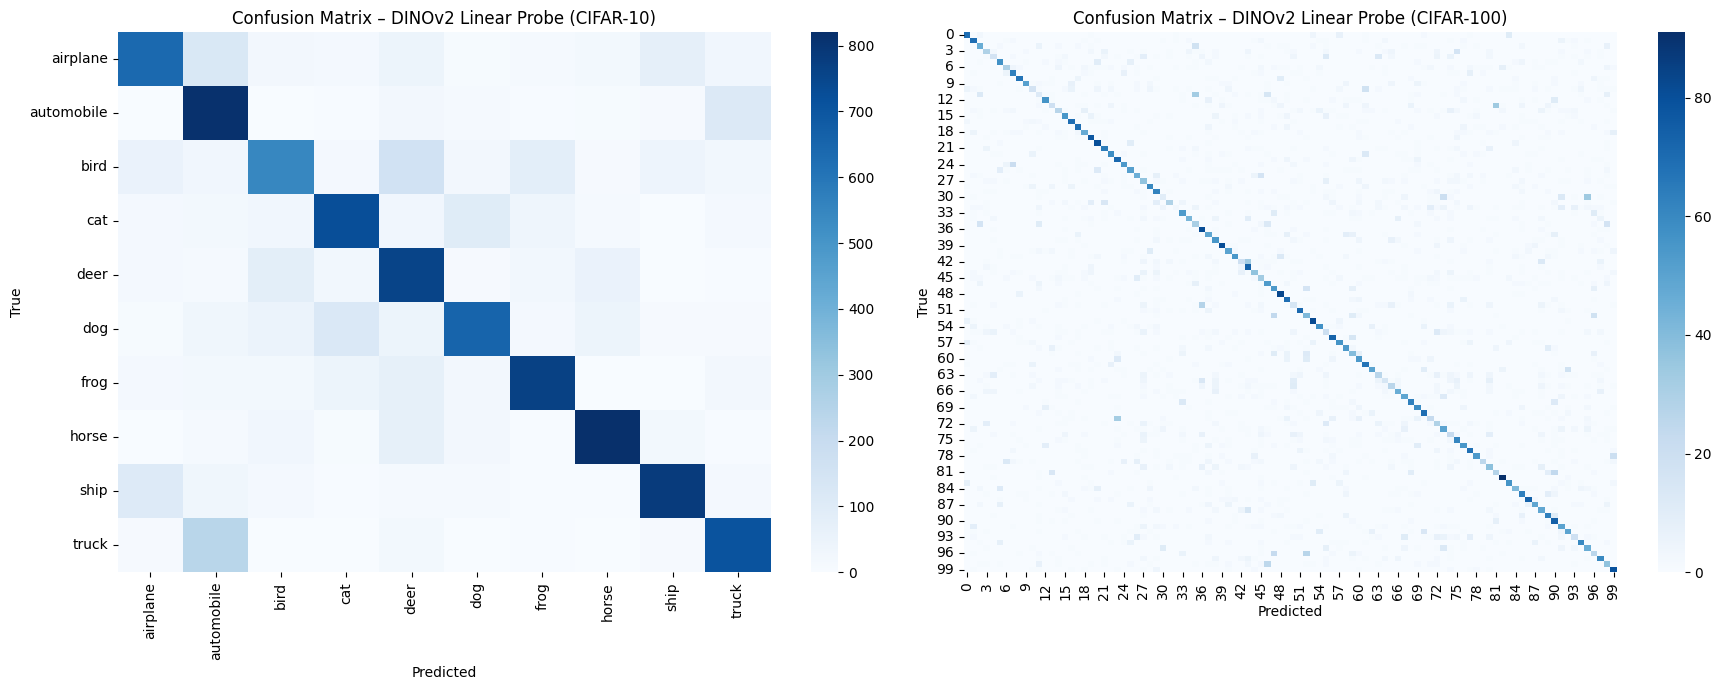

In [23]:

cm10 = confusion_matrix(y_test_10, preds_10)
cm100 = confusion_matrix(y_test_100, preds_100)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# CIFAR-10
sns.heatmap(
    cm10,
    ax=axes[0],
    cmap="Blues",
    xticklabels=train_set_10.classes,
    yticklabels=train_set_10.classes
)
axes[0].set_title("Confusion Matrix – DINOv2 Linear Probe (CIFAR-10)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# CIFAR-100
sns.heatmap(
    cm100,
    ax=axes[1],
    cmap="Blues",
    # xticklabels=train_set_100.classes,
    # yticklabels=train_set_100.classes
)
axes[1].set_title("Confusion Matrix – DINOv2 Linear Probe (CIFAR-100)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()